In [116]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from symbolic_control import (
    IntegratorDynamics, Abstraction,
    RegionLabeler, regex_to_nfa,
    ProductSynthesis, ProductState
)

In [117]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from symbolic_control import IntegratorDynamics, Abstraction, ProductSynthesis

## Configuration Parameters

In [118]:
# ============================================================
# GRID PARAMETERS
# ============================================================
x_min, x_max = -5.0, 5.0    # Grid x bounds
y_min, y_max = -5.0, 5.0    # Grid y bounds
eta = 0.2                   # Cell size (larger for faster testing)

# ============================================================
# DYNAMICS PARAMETERS
# ============================================================
tau = 0.5                   # Time step
w_bound = 0.1               # Disturbance bound
u_values = np.linspace(-1, 1, num=5)  # Control values per axis

In [119]:
# ============================================================
# REGIONS (named regions for the specification)
# Format: 'name': [x_min, x_max, y_min, y_max]
# ============================================================
regions = {
    # Waypoint regions
    'A': [-4.5, -3, -4.5, -3],     # Bottom-left corner
    'B': [3, 4.5, 3, 4.5],          # Top-right corner
    'C': [-4, -3, -1, 1],
    
    # Obstacles
    'obs1': [-1, 1, -1, 1],         # Center obstacle
    'obs2': [-3, -1, 2, 4],         # Top-left obstacle
    'obs3': [1, 3, -3, 0],          # Bottom-right obstacle
    'obs4': [1, 2, 3, 4],
    'obs5': [-2, -1.5, -3, 1]
}

# Names of obstacle regions
obstacle_names = {'obs1', 'obs2', 'obs3', 'obs4', 'obs5'}

# ============================================================
# SPECIFICATION (Regular Expression)
# ============================================================
# Simple spec: Visit A, then visit B
spec = "ABCB"

# ============================================================
# START POSITION
# ============================================================
start_position = np.array([0.0, -4.0])

## Setup Dynamics and Abstraction

In [120]:
# Create dynamics
dynamics = IntegratorDynamics(tau=tau, w_bound=w_bound, u_values=u_values)
print(f"Control set: {len(dynamics.control_set)} controls")

# Create abstraction
abstraction = Abstraction(
    dynamics=dynamics,
    state_bounds=np.array([[x_min, x_max], [y_min, y_max]]),
    eta=eta
)
nx, ny = abstraction.grid_shape
print(f"\nGrid: {nx} x {ny} = {abstraction.num_cells} cells")

# Build transitions
print("\nBuilding transitions...")
abstraction.build_transitions()
print(f"Total transitions: {len(abstraction.transitions)}")

Control set: 25 controls

Grid: 50 x 50 = 2500 cells

Building transitions...
Building transitions for 2500 cells × 25 controls...
Done. Total transitions: 62500
Total transitions: 62500


## Run Product Synthesis

In [121]:
# Create product synthesis and run
synth = ProductSynthesis(
    abstraction=abstraction,
    obstacles=obstacle_names,
    regions=regions,
    spec=spec
)

winning_set = synth.run(verbose=True)

Specification: ABCB
NFA states: 8, alphabet: {'A', 'B', 'C'}

SAFETY SYNTHESIS (Automaton Pruning)
Qₛ: 2085 cells | R₀: 2085 cells
Iteration 1: 2085 cells (removed 0)
Converged! S* = 2085 cells (83.4%)
Safe transitions: 40821
PRODUCT AUTOMATON CONSTRUCTION
Initial product states: 2085
Accepting in initial: 0
  Explored 10000 states, queue size: 255
Product states: 11791
Accepting states: 1966
Product transitions: 227534
PRODUCT REACHABILITY SYNTHESIS
Target (accepting): 1966 product states
R₀: 1966 states
Iteration 1: 2054 states (+88)
Iteration 2: 2110 states (+56)
Iteration 3: 2164 states (+54)
Iteration 4: 2226 states (+62)
Iteration 5: 2299 states (+73)
Iteration 6: 2377 states (+78)
Iteration 7: 2460 states (+83)
Iteration 8: 2520 states (+60)
Iteration 9: 2580 states (+60)
Iteration 10: 2632 states (+52)
Iteration 11: 2676 states (+44)
Iteration 12: 2722 states (+46)
Iteration 13: 2772 states (+50)
Iteration 14: 2826 states (+54)
Iteration 15: 2898 states (+72)
Iteration 16: 2984

## Visualize Results

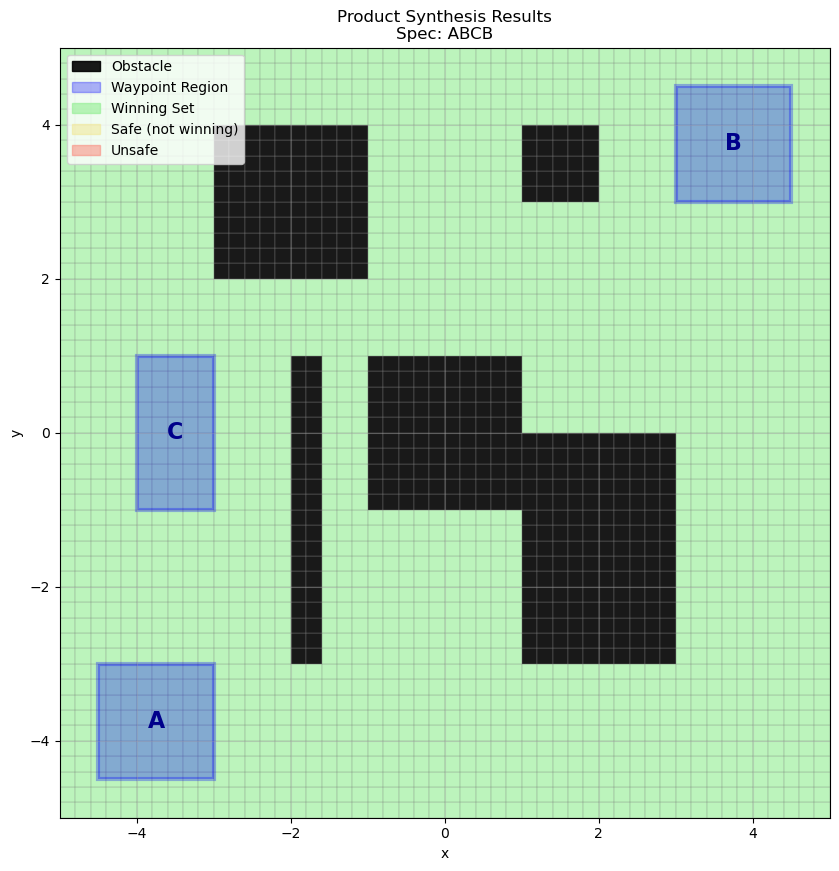

In [122]:
def visualize_product_synthesis(synth, ax=None, title="Product Synthesis Results"):
    """Visualize the product synthesis results."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    abst = synth.abstraction
    nx, ny = abst.grid_shape
    
    # Get winning cells
    winning_cells = synth.get_winning_cells()
    safe_cells = synth.safe_automaton.safe_states if synth.safe_automaton else set()
    
    # Draw cells
    for i in range(nx):
        for j in range(ny):
            cell_idx = np.ravel_multi_index((i, j), abst.grid_shape)
            x = abst.state_bounds[0, 0] + i * abst.eta
            y = abst.state_bounds[1, 0] + j * abst.eta
            
            # Determine color
            if cell_idx in synth.obstacle_cells:
                color = 'black'
                alpha = 0.9
            elif cell_idx in winning_cells:
                color = 'lightgreen'
                alpha = 0.6
            elif cell_idx in safe_cells:
                color = 'khaki'
                alpha = 0.5
            else:
                color = 'salmon'
                alpha = 0.5
            
            rect = mpatches.Rectangle(
                (x, y), abst.eta, abst.eta,
                linewidth=0.3, edgecolor='gray',
                facecolor=color, alpha=alpha
            )
            ax.add_patch(rect)
    
    # Draw named regions
    for name, bounds in synth.regions.items():
        if name not in synth.obstacle_names:
            rect = mpatches.Rectangle(
                (bounds[0], bounds[2]), bounds[1] - bounds[0], bounds[3] - bounds[2],
                linewidth=3, edgecolor='blue', facecolor='blue', alpha=0.3
            )
            ax.add_patch(rect)
            ax.text(
                (bounds[0] + bounds[1]) / 2,
                (bounds[2] + bounds[3]) / 2,
                name, fontsize=16, fontweight='bold',
                ha='center', va='center', color='darkblue'
            )
    
    # Legend
    legend_patches = [
        mpatches.Patch(color='black', alpha=0.9, label='Obstacle'),
        mpatches.Patch(color='blue', alpha=0.3, label='Waypoint Region'),
        mpatches.Patch(color='lightgreen', alpha=0.6, label='Winning Set'),
        mpatches.Patch(color='khaki', alpha=0.5, label='Safe (not winning)'),
        mpatches.Patch(color='salmon', alpha=0.5, label='Unsafe'),
    ]
    ax.legend(handles=legend_patches, loc='upper left')
    
    ax.set_xlim(abst.state_bounds[0, 0], abst.state_bounds[0, 1])
    ax.set_ylim(abst.state_bounds[1, 0], abst.state_bounds[1, 1])
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"{title}\nSpec: {synth.spec}")
    ax.grid(True, alpha=0.3)
    
    return ax

fig, ax = plt.subplots(figsize=(10, 10))
visualize_product_synthesis(synth, ax)
plt.show()

## Simulate Controller

In [123]:
# Check if start position is in winning set
start_cell = synth.abstraction.point_to_cell(start_position)
initial_nfa = frozenset(synth.nfa.get_initial_states())

print(f"Start position: {start_position}")
print(f"Start cell: {start_cell}")
print(f"Initial NFA states: {initial_nfa}")
print(f"In winning set: {synth.is_winning(initial_nfa, start_cell)}")

Start position: [ 0. -4.]
Start cell: 1255
Initial NFA states: frozenset({0})
In winning set: True


In [124]:
# Run simulation
trajectory, nfa_trace = synth.simulate(start_position, max_steps=100, verbose=True)
print(f"\nTrajectory length: {len(trajectory)} steps")
print(f"Final NFA states: {nfa_trace[-1] if nfa_trace else 'N/A'}")
print(f"Reached accepting: {synth.is_accepting(nfa_trace[-1]) if nfa_trace else False}")

Step 61: Reached accepting state at [3.10684021 3.41235911]

Trajectory length: 62 steps
Final NFA states: frozenset({7})
Reached accepting: True


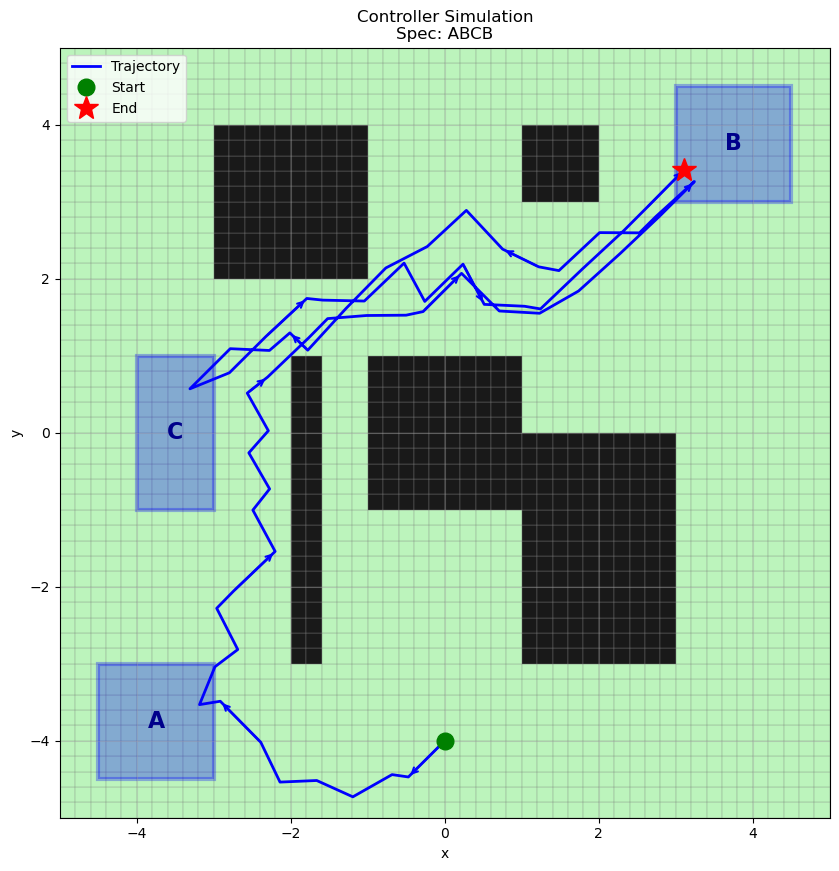

In [125]:
# Visualize trajectory
fig, ax = plt.subplots(figsize=(10, 10))
visualize_product_synthesis(synth, ax, title="Controller Simulation")

# Plot trajectory
ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, label='Trajectory', zorder=10)
ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=12, label='Start', zorder=11)
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'r*', markersize=18, label='End', zorder=11)

# Add arrows to show direction
n_arrows = min(10, len(trajectory) - 1)
step = max(1, len(trajectory) // n_arrows)
for i in range(0, len(trajectory) - 1, step):
    dx = trajectory[i+1, 0] - trajectory[i, 0]
    dy = trajectory[i+1, 1] - trajectory[i, 1]
    ax.annotate('', xy=(trajectory[i+1, 0], trajectory[i+1, 1]),
                xytext=(trajectory[i, 0], trajectory[i, 1]),
                arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
                zorder=10)

ax.legend(loc='upper left')
plt.show()

## Summary Statistics

In [126]:
nx, ny = abstraction.grid_shape
winning_cells = synth.get_winning_cells()

print("=" * 50)
print("PRODUCT SYNTHESIS SUMMARY")
print("=" * 50)
print(f"Specification: {spec}")
print(f"Grid: {nx} x {ny} = {abstraction.num_cells} cells")
print(f"Cell size (eta): {eta}")
print(f"")
print(f"NFA states: {len(synth.nfa.states)}")
print(f"NFA alphabet: {synth.nfa.alphabet}")
print(f"")
print(f"Product states: {len(synth.product.states)}")
print(f"Product accepting: {len(synth.product.accepting_states)}")
print(f"")
print(f"Safe cells: {len(synth.safe_automaton.safe_states)} ({100*len(synth.safe_automaton.safe_states)/abstraction.num_cells:.1f}%)")
print(f"Winning product states: {len(synth.winning_set)}")
print(f"Winning cells: {len(winning_cells)} ({100*len(winning_cells)/abstraction.num_cells:.1f}%)")
print(f"Reachability iterations: {len(synth.reach_sets) - 1}")

PRODUCT SYNTHESIS SUMMARY
Specification: ABCB
Grid: 50 x 50 = 2500 cells
Cell size (eta): 0.2

NFA states: 8
NFA alphabet: {'A', 'B', 'C'}

Product states: 11791
Product accepting: 1966

Safe cells: 2085 (83.4%)
Winning product states: 9558
Winning cells: 2085 (83.4%)
Reachability iterations: 86


---

## Try Different Specifications

You can modify the spec and regions to test different behaviors:

- `"AB"` - Visit A, then B (sequential)
- `"BA"` - Visit B, then A (reverse order)
- `"A|B"` - Visit A or B (choice)
- `"(A|B)"` - Same as above with parentheses
- `"A*B"` - Visit A any number of times, then B

## Configuration Parameters

In [127]:
# ============================================================
# GRID PARAMETERS
# ============================================================
x_min, x_max = 0.0, 10.0
y_min, y_max = 0.0, 10.0
eta = 0.5

# ============================================================
# DYNAMICS PARAMETERS
# ============================================================
tau = 0.7
w_bound = 0.1
u_values = np.linspace(-1, 1, num=10)

In [128]:
# ============================================================
# REGIONS (labeled areas on the grid)
# Format: {name: [x_min, x_max, y_min, y_max]}
# ============================================================
regions = {
    "A": [1.0, 3.0, 1.0, 3.0],     # Bottom-left region
    "B": [7.0, 9.0, 1.0, 3.0],     # Bottom-right region
    "C": [4.0, 6.0, 7.0, 9.0],     # Top-center (goal)
    "obs1": [4.0, 6.0, 3.0, 5.0],  # Center obstacle (now named)
}

# Names of obstacle regions
obstacle_names = {'obs1'}

# ============================================================
# SPECIFICATION (Regular Expression)
# ============================================================
# "ABC" means: visit A, then B, then C
specification = "ABC"

# ============================================================
# START POSITION
# ============================================================
start_position = np.array([2.0, 2.0])

## Setup Dynamics and Abstraction

In [129]:
# Create dynamics
dynamics = IntegratorDynamics(tau=tau, w_bound=w_bound, u_values=u_values)
print(f"Control set: {len(dynamics.control_set)} controls")

# Create abstraction
abstraction = Abstraction(
    dynamics=dynamics,
    state_bounds=np.array([[x_min, x_max], [y_min, y_max]]),
    eta=eta
)
nx, ny = abstraction.grid_shape
print(f"Grid: {nx} x {ny} = {abstraction.num_cells} cells")

# Build transitions
print("\nBuilding transitions...")
abstraction.build_transitions()

Control set: 100 controls
Grid: 20 x 20 = 400 cells

Building transitions...
Building transitions for 400 cells × 100 controls...
Done. Total transitions: 40000


## Run Product Synthesis

In [130]:
# Create and run synthesis
synth = ProductSynthesis(
    abstraction=abstraction,
    obstacles=obstacle_names,
    regions=regions,
    spec=specification
)
winning_set = synth.run(verbose=True)

Specification: ABC
NFA states: 6, alphabet: {'A', 'B', 'C'}

SAFETY SYNTHESIS (Automaton Pruning)
Qₛ: 384 cells | R₀: 384 cells
Iteration 1: 384 cells (removed 0)
Converged! S* = 384 cells (96.0%)
Safe transitions: 31736
PRODUCT AUTOMATON CONSTRUCTION
Initial product states: 384
Accepting in initial: 0
Product states: 1776
Accepting states: 352
Product transitions: 144280
PRODUCT REACHABILITY SYNTHESIS
Target (accepting): 352 product states
R₀: 352 states
Iteration 1: 372 states (+20)
Iteration 2: 400 states (+28)
Iteration 3: 426 states (+26)
Iteration 4: 456 states (+30)
Iteration 5: 486 states (+30)
Iteration 6: 520 states (+34)
Iteration 7: 558 states (+38)
Iteration 8: 600 states (+42)
Iteration 9: 614 states (+14)
Iteration 10: 628 states (+14)
Iteration 11: 660 states (+32)
Iteration 12: 696 states (+36)
Iteration 13: 733 states (+37)
Iteration 14: 772 states (+39)
Iteration 15: 795 states (+23)
Iteration 16: 810 states (+15)
Iteration 17: 829 states (+19)
Iteration 18: 850 stat

## Visualize Results

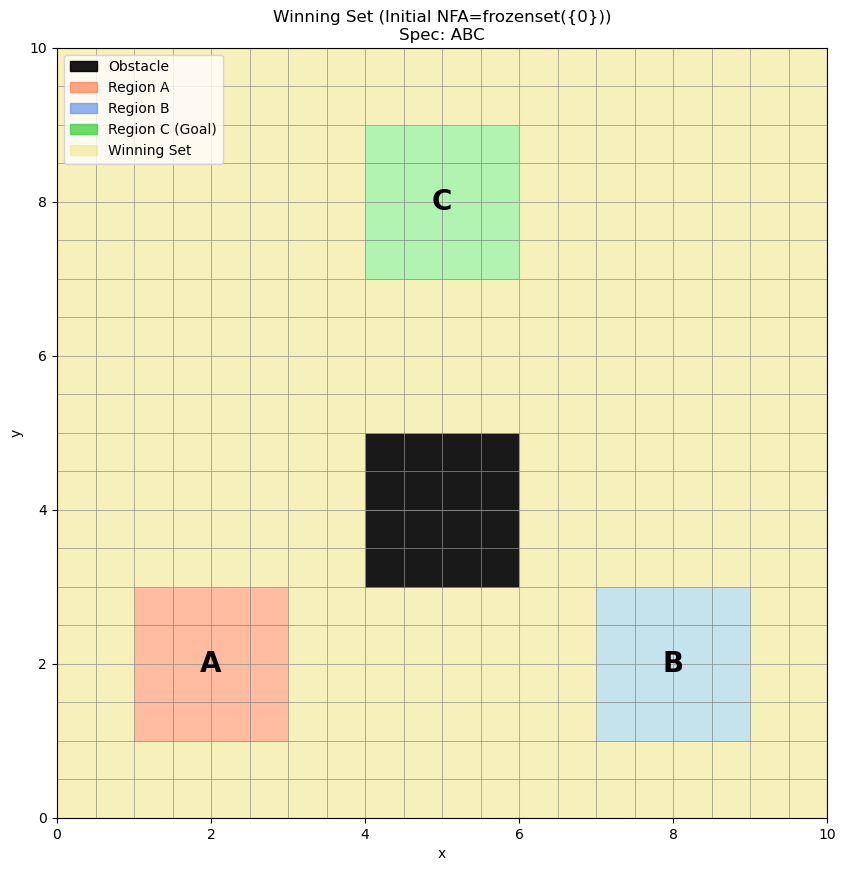


Initial NFA states: frozenset({0})
Winning cells for initial state: 336


In [131]:
def visualize_product_synthesis(synth, nfa_states, ax=None, title=""):
    """Visualize winning cells for a specific NFA state."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    abst = synth.abstraction
    nx, ny = abst.grid_shape
    winning_cells = synth.get_winning_cells_for_nfa_state(nfa_states)
    
    # Draw cells
    for i in range(nx):
        for j in range(ny):
            cell_idx = np.ravel_multi_index((i, j), abst.grid_shape)
            x = abst.state_bounds[0, 0] + i * abst.eta
            y = abst.state_bounds[1, 0] + j * abst.eta
            
            # Get label
            center = np.array([x + abst.eta/2, y + abst.eta/2])
            label = synth.labeler.get_label(center)
            
            # Determine color
            if cell_idx in synth.obstacle_cells:
                color = 'black'
                alpha = 0.9
            elif label == 'A':
                color = 'coral' if cell_idx in winning_cells else 'lightsalmon'
                alpha = 0.7
            elif label == 'B':
                color = 'cornflowerblue' if cell_idx in winning_cells else 'lightblue'
                alpha = 0.7
            elif label == 'C':
                color = 'limegreen' if cell_idx in winning_cells else 'lightgreen'
                alpha = 0.7
            elif cell_idx in winning_cells:
                color = 'khaki'
                alpha = 0.6
            else:
                color = 'lightgray'
                alpha = 0.3
            
            rect = mpatches.Rectangle(
                (x, y), abst.eta, abst.eta,
                linewidth=0.5, edgecolor='gray',
                facecolor=color, alpha=alpha
            )
            ax.add_patch(rect)
    
    # Draw region labels (skip obstacles)
    for name, bounds in synth.regions.items():
        if name not in synth.obstacle_names:
            cx = (bounds[0] + bounds[1]) / 2
            cy = (bounds[2] + bounds[3]) / 2
            ax.text(cx, cy, name, fontsize=20, ha='center', va='center', fontweight='bold')
    
    # Legend
    legend_patches = [
        mpatches.Patch(color='black', alpha=0.9, label='Obstacle'),
        mpatches.Patch(color='coral', alpha=0.7, label='Region A'),
        mpatches.Patch(color='cornflowerblue', alpha=0.7, label='Region B'),
        mpatches.Patch(color='limegreen', alpha=0.7, label='Region C (Goal)'),
        mpatches.Patch(color='khaki', alpha=0.6, label='Winning Set'),
    ]
    ax.legend(handles=legend_patches, loc='upper left')
    
    ax.set_xlim(abst.state_bounds[0, 0], abst.state_bounds[0, 1])
    ax.set_ylim(abst.state_bounds[1, 0], abst.state_bounds[1, 1])
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title or f"Winning Set for NFA state {nfa_states}")
    ax.grid(True, alpha=0.3)
    
    return ax

# Visualize for initial NFA state
initial_nfa = synth.get_initial_nfa_states()
fig, ax = plt.subplots(figsize=(10, 10))
visualize_product_synthesis(synth, initial_nfa, ax, 
    title=f"Winning Set (Initial NFA={initial_nfa})\nSpec: {specification}")
plt.show()

print(f"\nInitial NFA states: {initial_nfa}")
print(f"Winning cells for initial state: {len(synth.get_winning_cells_for_nfa_state(initial_nfa))}")

## Simulate Controller

In [132]:
# Check if start is in winning set
start_cell = abstraction.point_to_cell(start_position)
initial_nfa = synth.get_initial_nfa_states()

# Update NFA for initial position label
start_nfa = synth.update_nfa_states(initial_nfa, start_cell)

print(f"Start position: {start_position}")
print(f"Start cell: {start_cell}")
print(f"Start label: {synth.product._get_cell_label(start_cell)}")
print(f"Initial NFA state: {start_nfa}")
print(f"In winning set: {synth.is_winning(start_nfa, start_cell)}")
print(f"Distance to accepting: {synth.get_distance_to_accepting(start_nfa, start_cell)} steps")

Start position: [2. 2.]
Start cell: 84
Start label: A
Initial NFA state: frozenset({1, 2})
In winning set: False
Distance to accepting: -1 steps



SIMULATION
Step 15: Reached accepting state at [5.44763783 7.45166317]


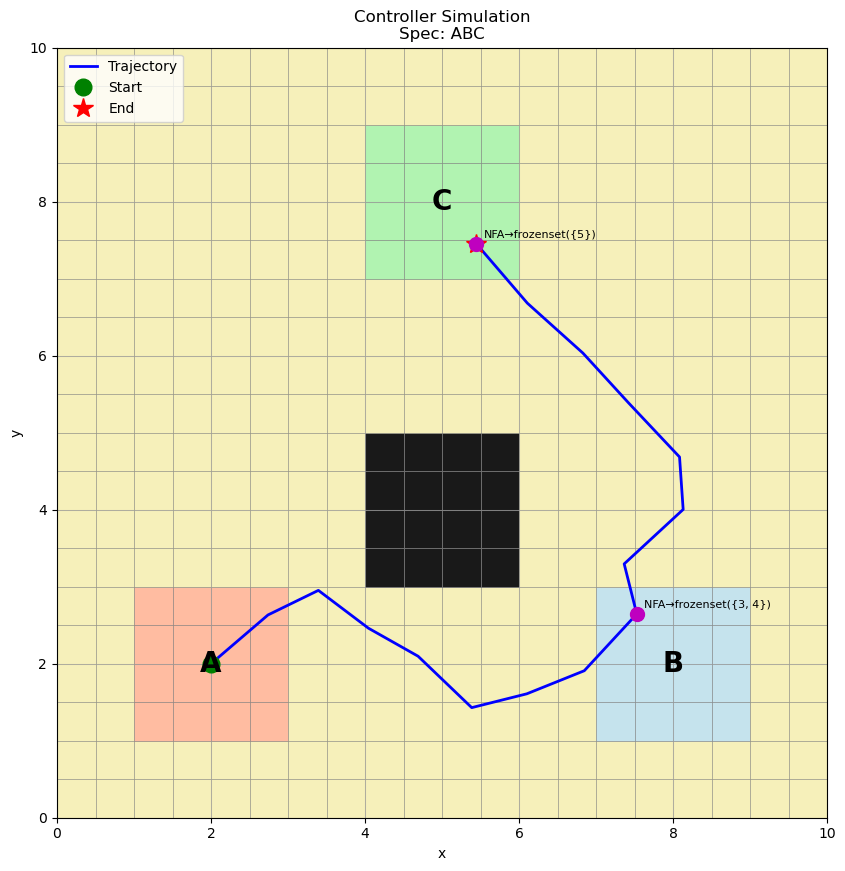


Trajectory length: 16 steps
Final NFA state: frozenset({5})
Mission complete: True


In [133]:
# Run simulation
print("\n" + "="*50)
print("SIMULATION")
print("="*50)
trajectory, nfa_history = synth.simulate(start_position, max_steps=50)


#############################

# Visualize trajectory
fig, ax = plt.subplots(figsize=(10, 10))
visualize_product_synthesis(synth, initial_nfa, ax, 
    title=f"Controller Simulation\nSpec: {specification}")

# Plot trajectory
ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, label='Trajectory')
ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=12, label='Start')
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'r*', markersize=15, label='End')

# Mark key waypoints with NFA state changes
for i in range(1, len(nfa_history)):
    if nfa_history[i] != nfa_history[i-1]:
        ax.plot(trajectory[i, 0], trajectory[i, 1], 'mo', markersize=10)
        ax.annotate(f'NFA→{nfa_history[i]}', 
                   (trajectory[i, 0], trajectory[i, 1]),
                   textcoords="offset points", xytext=(5,5), fontsize=8)

ax.legend(loc='upper left')
plt.show()

print(f"\nTrajectory length: {len(trajectory)} steps")
print(f"Final NFA state: {nfa_history[-1]}")
print(f"Mission complete: {synth.is_accepting(nfa_history[-1])}")

## Summary

In [134]:
print("=" * 50)
print("PRODUCT SYNTHESIS SUMMARY")
print("=" * 50)
print(f"Specification: {specification}")
print(f"")
print(f"Grid: {nx} x {ny} = {abstraction.num_cells} cells")
print(f"NFA states: {len(synth.nfa.states)}")
print(f"Product states: {len(synth.product.states)}")
print(f"Accepting states: {len(synth.product.accepting_states)}")
print(f"")
print(f"Winning set: {len(synth.winning_set)} product states")
print(f"Controller covers: {len(synth.controller)} states")
print(f"")
print(f"Regions:")
for name, bounds in regions.items():
    print(f"  {name}: [{bounds[0]}-{bounds[1]}] x [{bounds[2]}-{bounds[3]}]")

PRODUCT SYNTHESIS SUMMARY
Specification: ABC

Grid: 20 x 20 = 400 cells
NFA states: 6
Product states: 1776
Accepting states: 352

Winning set: 1392 product states
Controller covers: 1392 states

Regions:
  A: [1.0-3.0] x [1.0-3.0]
  B: [7.0-9.0] x [1.0-3.0]
  C: [4.0-6.0] x [7.0-9.0]
  obs1: [4.0-6.0] x [3.0-5.0]
